In [1]:
import numpy as np
def generate_cont_timeseries(dim=1, length=2000, num_changepoints=100):
    """
    Generate continuous valued time series with changepoints
    """
    changepoint_indices = np.random.choice(range(0, length-1), num_changepoints)

In [3]:
def generate_four_changepoints(dim=1, length=1000, means=[5,25,10,40]):
    start = 0
    changepoint_intervals = int(np.floor(length / len(means)))
    time_series = []
    for m in means:
        time_series.extend(np.random.normal(int(m),2, changepoint_intervals))
    return time_series    

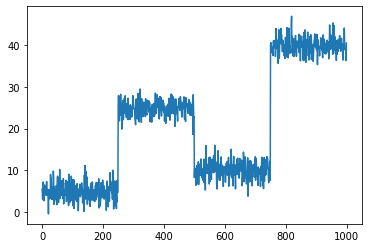

In [4]:
import matplotlib.pyplot as plt

ts = generate_four_changepoints()
plt.plot(ts)

In [ ]:
import tensorflow as tf
import numpy as np
# Implementing Variational RNN's and variations by subclassing Keras RNN-type Cells

class VRNNCell(tf.keras.layers.GRUCell):
    def __init__(self, units, output_dim, **kwargs):
        super(VRNNCell, self).__init__(units, **kwargs)
        self.output_dim = output_dim
    

    def build(self, input_shape):
        # Taking most of the standard weight initiaalizations from the base GRU class
        super().build((input_shape[0], input_shape[1] + self.units))
        
        self.input_kernel = self.add_weight(shape=(input_shape[-1], input_shape[-1]), name="layer", initializer='truncated_normal')
        
        self.prior_kernel = self.add_weight(shape=(self.units, self.units),name="layer", initializer='truncated_normal')
        
        self.pos_kernel = self.add_weight(shape=(input_shape[-1] + self.units,input_shape[-1] + self.units), name="layer", initializer='truncated_normal')
        
        self.encoder_mu_kernel = self.add_weight(shape=(input_shape[-1] + self.units, self.units), name="layer", initializer='truncated_normal')
        
        self.encoder_logvar_kernel = self.add_weight(shape=(input_shape[-1] + self.units, self.units), name="layer", initializer='truncated_normal')
        
        self.prior_mu_kernel = self.add_weight(shape=(self.units, self.units), name="layer", initializer='truncated_normal')
        
        self.prior_logvar_kernel = self.add_weight(shape=(self.units, self.units), name="layer", initializer='truncated_normal')  
        
        self.z_kernel = self.add_weight(shape=(self.units, self.units), name="layer", initializer='truncated_normal')
        
        self.output_kernel = self.add_weight(shape=(self.units + self.units, self.output_dim), name="layer", initializer='truncated_normal')


    def sample(self, mu, log_var):
        # Sample from unit Normal
        dims = tf.shape(mu)
        epsilon = tf.random.normal(dims)
        # All element-wise computations
        std = tf.math.exp(0.5 * log_var)
        z = tf.math.multiply(std, epsilon) + mu
        return z
    
    def call(self, inputs, states, training=False):
        # Some formulations:
        # Generation:
        # z_t ~ N(mu_(0, t), sigma_(0,t)), w here [mu_(0,t), sigma(0,t)] = phi_prior(h_(t-1))
        # Update: 
        # h_t = f_theta(h_(t-1), z_t, x_t) *recurrence equation
        # Inference:
        # z_t ~ N(mu_z, sigma_z), where [mu_z, sigma_z] = phi_post(x_t, h_(t-1))
        #
        # Let the base RNN cell handle the rest and add loss
        
        if training:
            x_t = tf.matmul(inputs, self.input_kernel)
            h_prev = states[0]

            prior = tf.matmul(h_prev, self.prior_kernel)
            p_mu = tf.matmul(prior, self.prior_mu_kernel)
            p_logvar = tf.matmul(prior, self.prior_logvar_kernel)
            
            input_state_concat = tf.concat([x_t, h_prev], axis=1)
            
            pos = tf.matmul(input_state_concat, self.pos_kernel)
            q_mu = tf.matmul(pos, self.encoder_mu_kernel)
            q_logvar = tf.matmul(pos, self.encoder_logvar_kernel)
            z_t = self.sample(q_mu, q_logvar)
            phi_z_t = tf.matmul(z_t, self.z_kernel)
            
            inp = tf.concat([x_t, phi_z_t], axis=1)
            
            
            output = tf.nn.relu(tf.matmul(tf.concat([h_prev, phi_z_t], axis=1), self.output_kernel))
            
            _, h_next = super().call(inp, h_prev)
            
            all_output = (output, z_t, q_mu, p_mu, q_logvar, p_logvar)
            return all_output, h_next
        
        else:
            x_t = tf.matmul(inputs, self.input_kernel)
            h_prev = states[0]

            prior = tf.matmul(h_prev, self.prior_kernel)
            p_mu = tf.matmul(prior, self.prior_mu_kernel)
            p_logvar = tf.matmul(prior, self.prior_logvar_kernel)
            
            input_state_concat = tf.concat([x_t, h_prev], axis=1)
            
            pos = tf.matmul(input_state_concat, self.pos_kernel)
            q_mu = tf.matmul(pos, self.encoder_mu_kernel)
            q_logvar = tf.matmul(pos, self.encoder_logvar_kernel)
            z_t = self.sample(p_mu, p_logvar)
            phi_z_t = tf.matmul(z_t, self.z_kernel)
            
            inp = tf.concat([x_t, phi_z_t], axis=1)
            
            
            output = tf.nn.softmax(tf.matmul(tf.concat([h_prev, phi_z_t], axis=1), self.output_kernel))
            
            _, h_next = super().call(inp, h_prev)
            
            all_output = (z_t, q_mu, p_mu, q_logvar, p_logvar)
            return all_output, h_next
    
   
    def get_config(self):
        return {"units":self.units}

In [ ]:
def kl_gauss(posterior_means, prior_means, posterior_log_var, prior_log_var):   
    kl = prior_log_var - posterior_log_var + (tf.exp(posterior_log_var) + 
                                       tf.square(posterior_means - prior_means)) / tf.exp(prior_log_var) - 1
    kl = 0.5 * tf.reduce_sum(kl, axis=(1,2))
    return kl

class VRNNGRU(tf.keras.Model):
    def __init__(self, feature_space, latent_dim, timesteps,**kwargs):
        super(VRNNGRU, self).__init__(**kwargs)
        vrnn_cell = VRNNCell(latent_dim)
        self.latent_dim = latent_dim
        
        vrnn_input = keras.layers.Input(shape=(timesteps, feature_space))
        vrnn_output = keras.layers.RNN(vrnn_cell, return_sequences=True)(vrnn_input)
        self.vrnn = keras.Model(vrnn_input, vrnn_output)
        
        decoder_input = keras.layers.Input(shape=(timesteps, latent_dim))
        output =  keras.layers.TimeDistributed(keras.layers.Dense(feature_space, activation='softmax'))(decoder_input)
        self.decoder =keras.Model(decoder_input, output)
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            input_data = data[0]
            output_data = data[1]
            
            timesteps = input_data.shape[1]
            num_feats = input_data.shape[2]
        with tf.GradientTape() as tape:
            outputs = self.vrnn(input_data, training=True)
            z = outputs[0]
#             preds = self.decoder(z)
            
            q_mu = tf.squeeze(tf.squeeze(outputs[2]))
            p_mu = tf.squeeze(tf.squeeze(outputs[3]))
            q_log_var = tf.squeeze(tf.squeeze(outputs[4]))
            p_log_var = tf.squeeze(tf.squeeze(outputs[5]))
            
            kl_loss = tf.reduce_mean(kl_gauss(q_mu, p_mu, q_log_var, p_log_var))
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.categorical_crossentropy(output_data, preds), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss 
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)       
        return {
            'total_loss': self.total_loss_tracker.result(),
            'loss': self.reconstruction_loss_tracker.result(),
            'kl': self.kl_loss_tracker.result()
        }

    def call(self, inputs):
        outputs = self.vrnn(inputs, training=True)
        z = outputs[0]
        preds = self.decoder(z)
        return preds
    
    def generate(self, inputs):
        outputs = self.vrnn(inputs, training=False)
        z = outputs[0]
        preds = self.decoder(z)
        return (outputs[0], outputs[1])
    